In [2]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import cm


In [3]:
gaussian_norm = 1 / np.sqrt(np.pi)
gauss_points, gauss_weights = np.polynomial.hermite.hermgauss(300)
gauss_points = gauss_points * np.sqrt(2)

def Phi(mu, delta0, bias, thres):
    integrand = bias + np.tanh(mu + np.sqrt(delta0) * gauss_points - thres)
    return gaussian_norm * np.dot(integrand, gauss_weights)

def derPhi(mu, delta0, thres):
    integrand = 1 / (np.cosh(mu + np.sqrt(delta0) * gauss_points - thres) ** 2)
    return gaussian_norm * np.dot(integrand, gauss_weights)


In [4]:
N_E = 600
N_I = 200
N = 800
sigma = 0.45
thres = 2.1  # 阈值可根据需要调整
bias = 1.0   # 偏置可根据需要调整
n0 = np.zeros(N)


def system_equations(x, g, J0, tau_c):
    k1, k2 = x
    delta0 = (k2 ** 2)
    term1 = -k1 + (N_E - g * N_I) * J0 * Phi(k1, delta0, bias, thres) + sigma * np.sqrt(N * tau_c) * derPhi(k1, delta0, thres) * k2
    term2 = -k2 + sigma * np.sqrt(N * tau_c) * Phi(k1, delta0, bias, thres)
    return [term1, term2]


/Users/zhangmeiyi/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/zhangmeiyi/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


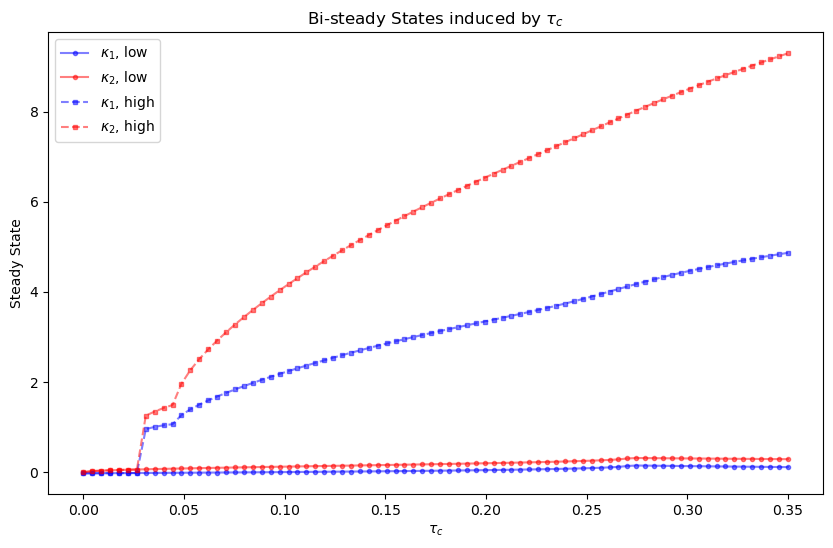

In [5]:
g = 4.5  # 给定g值
J0 = 0.003  # 给定J0值
tau_c_values = np.linspace(0.0, 0.35, 80)


# 存储两种初始条件下的稳态解
steady_states_near_zero = []  # 存储初始值接近0时的解
steady_states_large = []      # 存储初始值较大时的解

for tau_c in tau_c_values:
    # 初始猜测值1：接近0
    initial_guess_near_zero = [-0.001, -0.001]
    steady_state_near_zero = fsolve(system_equations, initial_guess_near_zero, args=(g, J0, tau_c))
    steady_states_near_zero.append(steady_state_near_zero)
    
    # 初始猜测值2：较大值
    initial_guess_large = [10.0, 10.0]
    steady_state_large = fsolve(system_equations, initial_guess_large, args=(g, J0, tau_c))
    steady_states_large.append(steady_state_large)

# 绘图时区分两种初始条件的解
# 提取kappa1和kappa2的值
kappa1_near_zero = [state[0] for state in steady_states_near_zero]
kappa2_near_zero = [state[1] for state in steady_states_near_zero]

kappa1_large = [state[0] for state in steady_states_large]
kappa2_large = [state[1] for state in steady_states_large]

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(tau_c_values, kappa1_near_zero, 'bo-', label='$\\kappa_1$, low', markersize=3, alpha=0.5)
plt.plot(tau_c_values, kappa2_near_zero, 'ro-', label='$\\kappa_2$, low', markersize=3, alpha=0.5)
plt.plot(tau_c_values, kappa1_large, 'bs--', label='$\\kappa_1$, high', markersize=3, alpha=0.5)
plt.plot(tau_c_values, kappa2_large, 'rs--', label='$\\kappa_2$, high', markersize=3, alpha=0.5)

plt.xlabel('$\\tau_c$')
plt.ylabel('Steady State')
plt.title('Bi-steady States induced by $\\tau_c$')
plt.legend()
plt.show()



In [6]:
def d_Phi_d_k2(k1, k2, thres):
    delta0 = k2 ** 2
    sqrt_delta0 = np.sqrt(delta0)
    # 积分函数：z * sech^2(...)
    integrand = gauss_points * (1 / np.cosh(k1 + sqrt_delta0 * gauss_points - thres) ** 2)
    # 乘以系数 k2 / sqrt(delta0)（即 k2/|k2|）和权重
    return (k2 / sqrt_delta0) * gaussian_norm * np.dot(integrand, gauss_weights)

def d_derPhi_d_k1(k1, k2, thres):
    delta0 = k2 ** 2
    sqrt_delta0 = np.sqrt(delta0)
    # 积分函数：-2 * sech^2(...) * tanh(...)
    integrand = -2 * (1 / np.cosh(k1 + sqrt_delta0 * gauss_points - thres) ** 2) * \
                np.tanh(k1 + sqrt_delta0 * gauss_points - thres)
    return gaussian_norm * np.dot(integrand, gauss_weights)

def d_derPhi_d_k2(k1, k2, thres):
    delta0 = k2 ** 2
    sqrt_delta0 = np.sqrt(delta0)
    # 积分函数：-2z * sech^2(...) * tanh(...)
    integrand = -2 * gauss_points * (1 / np.cosh(k1 + sqrt_delta0 * gauss_points - thres) ** 2) * \
                np.tanh(k1 + sqrt_delta0 * gauss_points - thres)
    # 乘以系数 k2 / sqrt(delta0)
    return (k2 / sqrt_delta0) * gaussian_norm * np.dot(integrand, gauss_weights)



In [7]:
def jacobian(x, g, J0, tau_c):
    k1, k2 = x
    delta0 = k2 ** 2
    d_phi_d_k1 = derPhi(k1, delta0, thres)
    d_phi_d_k2 = d_Phi_d_k2(k1, k2, thres)
    d_derphi_d_k1 = d_derPhi_d_k1(k1, k2, thres)
    d_derphi_d_k2 = d_derPhi_d_k2(k1, k2, thres)

    J = np.zeros((2, 2))
    J[0, 0] = -1 + (N_E - g * N_I) * J0 * d_phi_d_k1 + sigma * np.sqrt(N * tau_c) * d_derphi_d_k1 * k2 
    J[0, 1] = (N_E - g * N_I) * J0 * d_phi_d_k2 + sigma * np.sqrt(N * tau_c) * (d_derphi_d_k2 * k2 + derPhi(k1, delta0, thres))
    J[1, 0] = sigma * np.sqrt(N * tau_c) * d_phi_d_k1
    J[1, 1] = -1 + sigma * np.sqrt(N * tau_c) * d_phi_d_k2
    return J


/var/folders/d5/_yfwrx_97hz9k65168tj_cj40000gn/T/ipykernel_87288/283137944.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='$\\tau_c$')


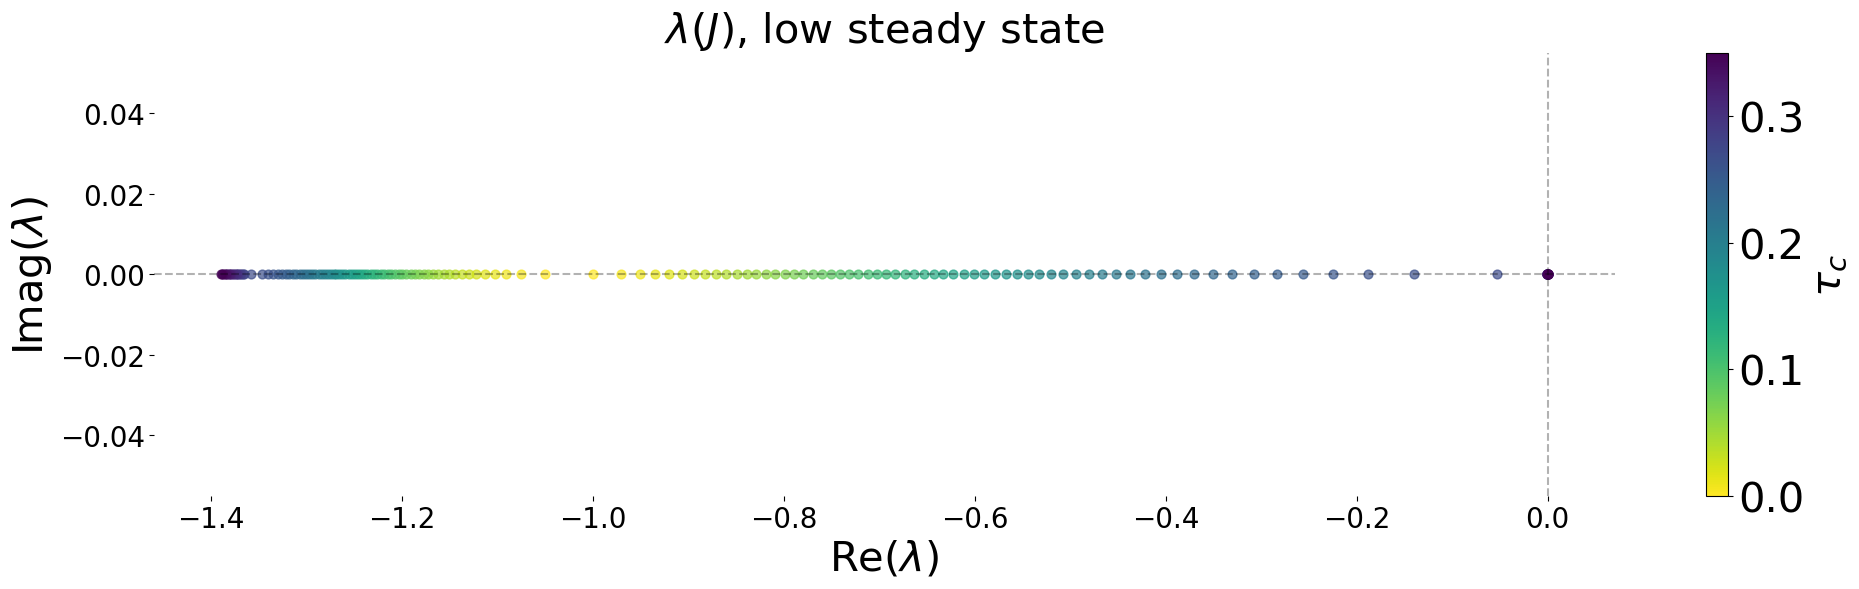

In [8]:

eigenvalues_list = []
for i in range (len (tau_c_values)):
    x = steady_states_near_zero[i]
    J = jacobian(x, g, J0, tau_c_values[i])
    eigenvalues = np.linalg.eigvals(J)
    eigenvalues_list.append(eigenvalues)

    norm = plt.Normalize (tau_c_values.min (), tau_c_values.max ())
    cmap = plt.cm.viridis_r # 反转的 viridis 映射
    
plt.figure(figsize=(20, 6))
for i in range(len(tau_c_values)):
    tau_c = tau_c_values[i]
    eigenvalues = eigenvalues_list[i]
    color = cmap(norm(tau_c))
    plt.scatter (eigenvalues.real, eigenvalues.imag,color=color, s=40, alpha=0.7,label=f'τ_c={tau_c:.3f}' if i % 30 == 0 else "") # 每 10 个点显示一个标签

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label='$\\tau_c$')
cbar.ax.set_ylabel('$\\tau_c$', fontsize=30)  # 颜色条标签字体大小
cbar.ax.tick_params(labelsize=30)  # 颜色条刻度字体大小

plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.xlabel('Re($\\lambda$)', fontsize=30)
plt.ylabel('Imag($\\lambda$)', fontsize=30)
plt.title('$\\lambda(J)$, low steady state', fontsize=30)
#plt.legend(title='Selected τ_c values', bbox_to_anchor=(1.05, 1), loc='upper left') # 显示图例（只显示部分点以避免拥挤）
# 调整坐标轴刻度字体大小
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)    # 去掉上边框
ax.spines['right'].set_visible(False)  # 去掉右边框
ax.spines['bottom'].set_visible(False) # 去掉下边框
ax.spines['left'].set_visible(False)   # 去掉左边框
plt.tight_layout()
plt.savefig('./results/BISTEADY_g4.5_j0.003_jacobi_low.png')
plt.show()


0.0
[-1.04988797 -1.        ]
0.004430379746835442
[-1.07518008 -0.97048751]
0.008860759493670885
[-1.0906503 -0.9507453]
0.013291139240506327
[-1.10269542 -0.93437512]
0.01772151898734177
[-1.11283377 -0.91985716]
0.022151898734177212
[-1.12171807 -0.90653709]
0.026582278481012654
[-1.12969985 -0.89406177]
0.031012658227848097
[-1.25049788e+00  2.81180196e-05]
0.03544303797468354
[-1.25926573e+00  1.59833376e-04]
0.03987341772151898
[-1.26465590e+00 -1.05077414e-03]
0.044303797468354424
[-1.26825704e+00 -5.30081123e-05]
0.04873417721518987
[-1.24630596 -0.37705989]
0.05316455696202531
[-1.24157682 -0.54156943]
0.05759493670886075
[-1.24225022 -0.64004111]
0.06202531645569619
[-1.2455467  -0.70794624]
0.06645569620253164
[-1.25039059 -0.75775092]
0.07088607594936708
[-1.25622888 -0.79561091]
0.07531645569620252
[-1.2627     -0.82515817]
0.07974683544303796
[-1.26945185 -0.84877252]
0.08417721518987341
[-1.27611207 -0.86803798]
0.08860759493670885
[-1.28237899 -0.88394629]
0.09303797468

/var/folders/d5/_yfwrx_97hz9k65168tj_cj40000gn/T/ipykernel_87288/3003136525.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='$\\tau_c$')


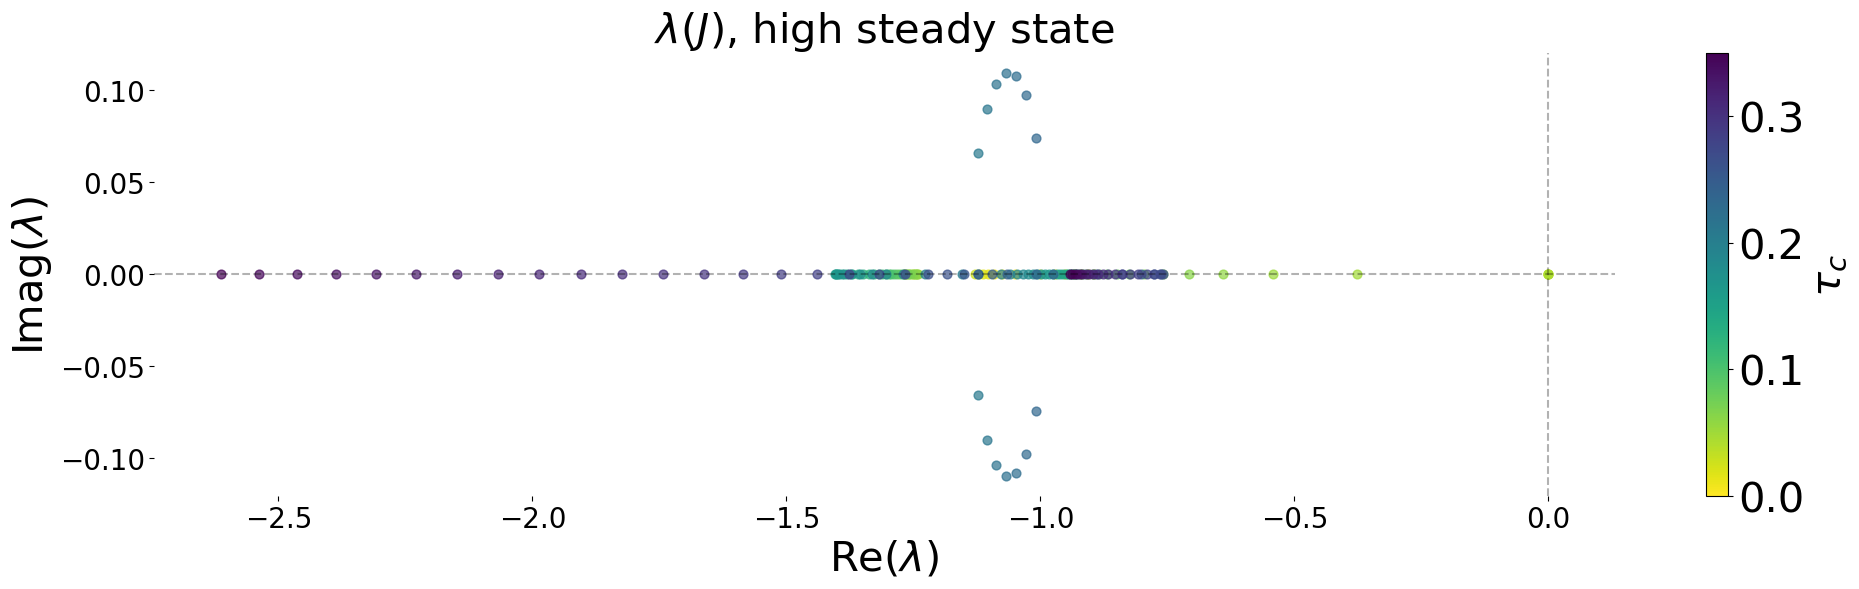

In [9]:

eigenvalues_list = []
for i in range (len (tau_c_values)):
    x = steady_states_large[i]
    J = jacobian(x, g, J0, tau_c_values[i])
    eigenvalues = np.linalg.eigvals(J)
    print(tau_c_values[i])
    print(eigenvalues)
    eigenvalues_list.append(eigenvalues)

    norm = plt.Normalize (tau_c_values.min (), tau_c_values.max ())
    cmap = plt.cm.viridis_r # 反转的 viridis 映射
    
plt.figure(figsize=(20, 6))
for i in range(len(tau_c_values)):
    tau_c = tau_c_values[i]
    eigenvalues = eigenvalues_list[i]
    color = cmap(norm(tau_c))
    plt.scatter (eigenvalues.real, eigenvalues.imag,color=color, s=40, alpha=0.7,label=f'τ_c={tau_c:.3f}' if i % 40 == 0 else "") # 每 10 个点显示一个标签
   
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label='$\\tau_c$')
cbar.ax.set_ylabel('$\\tau_c$', fontsize=30)  # 颜色条标签字体大小
cbar.ax.tick_params(labelsize=30)  # 颜色条刻度字体大小

plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.xlabel('Re($\\lambda$)', fontsize=30)
plt.ylabel('Imag($\\lambda$)', fontsize=30)
plt.title('$\\lambda(J)$, high steady state', fontsize=30)
#plt.legend(title='Selected τ_c values', bbox_to_anchor=(1.05, 1), loc='upper left') # 显示图例（只显示部分点以避免拥挤）
# 调整坐标轴刻度字体大小
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
ax.spines['top'].set_visible(False)    # 去掉上边框
ax.spines['right'].set_visible(False)  # 去掉右边框
ax.spines['bottom'].set_visible(False) # 去掉下边框
ax.spines['left'].set_visible(False)   # 去掉左边框
plt.tight_layout()
plt.savefig('./results/BISTEADY_g4.5_j0.003_jacobi_high.png')
plt.show()



In [10]:
def phi_vec(x_vec):
    return bias + np.tanh(x_vec - thres)

N_trials = 10
time_scale = 1.0
N_time= 2000
dt = 0.01
n0_vec = np.zeros(N)    
n0_vec[:N_E] = N*J0*np.ones(N_E)
n0_vec[N_E:] = -g*N*J0*np.ones(N_I)

In [11]:


def activity_simulation(tauc):
    
    e_vec = np.ones(N)
    eta_vec = np.random.normal(0,1,N)
    y_mat = np.random.normal(0,1,(N,N))
        
    m1_vec = e_vec
    m2_vec = eta_vec
    n1_vec = sigma * np.sqrt(N * tauc) * eta_vec + n0_vec
    n2_vec = sigma * np.sqrt(N * tauc) * e_vec
    J_mat = (1/N)*(np.outer(m1_vec, n1_vec)+np.outer(m2_vec, n2_vec)) + sigma * np.sqrt((1-2*tauc)/N)*y_mat
        
        
    x_rawdata = np.zeros((N, N_time))
    x0 = -0.001 * np.ones(N)
    x_rawdata[:, 0] = x0
    for t in range(N_time-1):
        x_rawdata[: ,t+1] = x_rawdata[:, t] + dt * (-x_rawdata[:, t] + J_mat @ phi_vec(x_rawdata[:, t])) / time_scale
    k1_low = np.inner(x_rawdata[:,-1], m1_vec) / np.inner(m1_vec, m1_vec)
    k2_low = np.inner(x_rawdata[:,-1], m2_vec) / np.inner(m2_vec, m2_vec)
    x0 = 10.0 * np.ones(N)
    x_rawdata[:, 0] = x0
    for t in range(N_time-1):
        x_rawdata[: ,t+1] = x_rawdata[:, t] + dt * (-x_rawdata[:, t] + J_mat @ phi_vec(x_rawdata[:, t])) / time_scale
    k1_high = np.inner(x_rawdata[:,-1], m1_vec) / np.inner(m1_vec, m1_vec)
    k2_high = np.inner(x_rawdata[:,-1], m2_vec) / np.inner(m2_vec, m2_vec)
    
    return k1_low, k2_low, k1_high, k2_high
        

In [12]:
k1_simu_low = np.zeros((len(tau_c_values), N_trials))
k2_simu_low = np.zeros((len(tau_c_values), N_trials))
k1_simu_high = np.zeros((len(tau_c_values), N_trials))
k2_simu_high = np.zeros((len(tau_c_values), N_trials))

for tauc_idx,tauc in enumerate(tau_c_values):
    print(f"Simulating for tau_c = {tauc:.3f}")
    for k_trial in range(N_trials):
        k1_l, k2_l, k1_h, k2_h = activity_simulation(tauc)
        k1_simu_low[tauc_idx, k_trial] = k1_l
        k2_simu_low[tauc_idx, k_trial] = k2_l
        k1_simu_high[tauc_idx, k_trial] = k1_h
        k2_simu_high[tauc_idx, k_trial] = k2_h

Simulating for tau_c = 0.000
Simulating for tau_c = 0.004
Simulating for tau_c = 0.009
Simulating for tau_c = 0.013
Simulating for tau_c = 0.018
Simulating for tau_c = 0.022
Simulating for tau_c = 0.027
Simulating for tau_c = 0.031
Simulating for tau_c = 0.035
Simulating for tau_c = 0.040
Simulating for tau_c = 0.044
Simulating for tau_c = 0.049
Simulating for tau_c = 0.053
Simulating for tau_c = 0.058
Simulating for tau_c = 0.062
Simulating for tau_c = 0.066
Simulating for tau_c = 0.071
Simulating for tau_c = 0.075
Simulating for tau_c = 0.080
Simulating for tau_c = 0.084
Simulating for tau_c = 0.089
Simulating for tau_c = 0.093
Simulating for tau_c = 0.097
Simulating for tau_c = 0.102
Simulating for tau_c = 0.106
Simulating for tau_c = 0.111
Simulating for tau_c = 0.115
Simulating for tau_c = 0.120
Simulating for tau_c = 0.124
Simulating for tau_c = 0.128
Simulating for tau_c = 0.133
Simulating for tau_c = 0.137
Simulating for tau_c = 0.142
Simulating for tau_c = 0.146
Simulating for

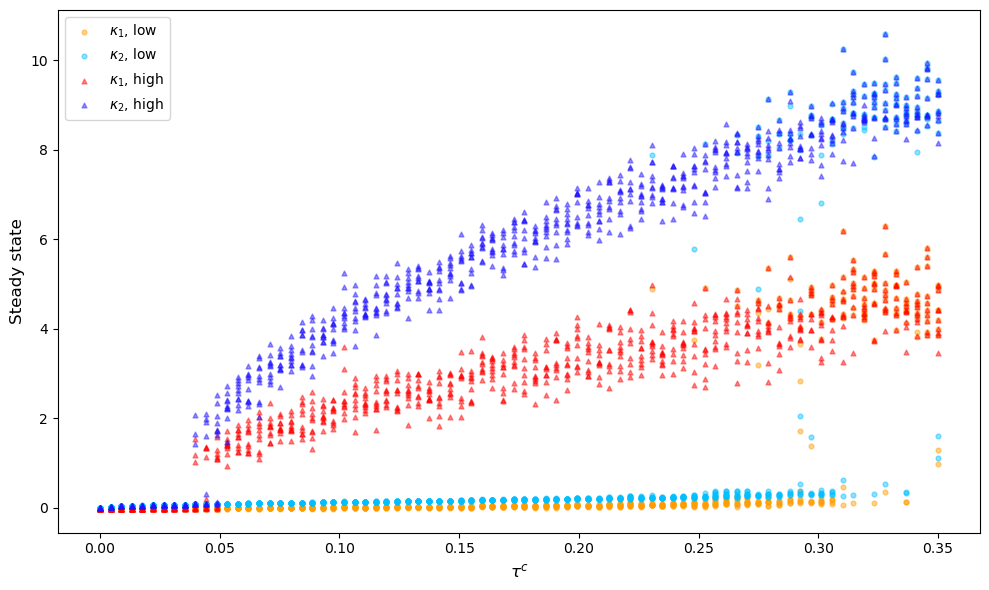

In [13]:
plt.figure(figsize=(10, 6))
alpha = 0.45  # 高透明度
s = 12       # 点大小
x = np.repeat(tau_c_values, N_trials)
plt.scatter(x, k1_simu_low.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_1$, low', marker='o', color="#FF9D00FF")
plt.scatter(x, k2_simu_low.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_2$, low', marker='o', color="#00BFFFFF")
plt.scatter(x, k1_simu_high.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_1$, high', marker='^', color="#FF0000FF")
plt.scatter(x, k2_simu_high.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_2$, high', marker='^', color="#2014FFFF")

# 添加标题和标签
plt.xlabel('$\\tau^c$', fontsize=12)
plt.ylabel('Steady state', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
        
     

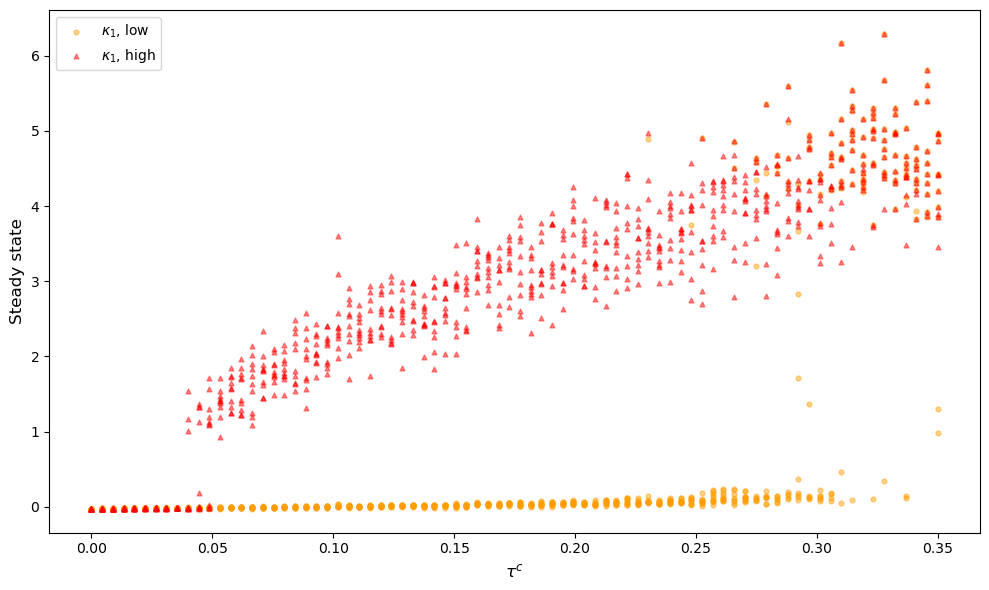

In [14]:
plt.figure(figsize=(10, 6))

# 定义透明度和点大小
alpha = 0.45  # 高透明度
s = 12       # 点大小
x = np.repeat(tau_c_values, N_trials)
plt.scatter(x, k1_simu_low.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_1$, low', marker='o', color="#FF9D00FF")
plt.scatter(x, k1_simu_high.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_1$, high', marker='^', color="#FF0000FF")

# 添加标题和标签
plt.xlabel('$\\tau^c$', fontsize=12)
plt.ylabel('Steady state', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
        
     

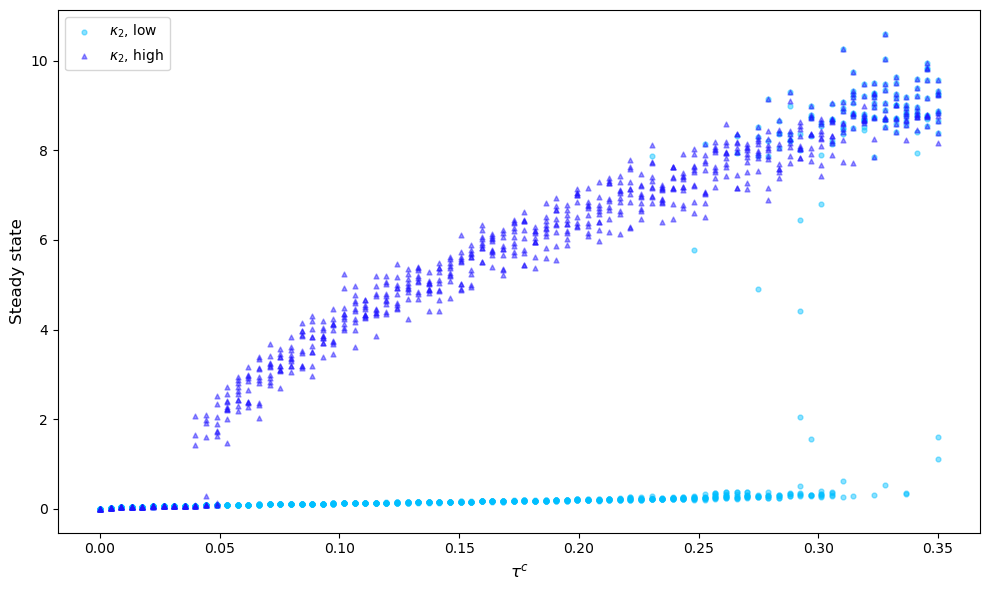

In [15]:
plt.figure(figsize=(10, 6))

alpha = 0.45  # 高透明度
s = 12       # 点大小

x = np.repeat(tau_c_values, N_trials)
plt.scatter(x, k2_simu_low.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_2$, low', marker='o', color="#00BFFFFF")
plt.scatter(x, k2_simu_high.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_2$, high', marker='^', color="#2014FFFF")

# 添加标题和标签
plt.xlabel('$\\tau^c$', fontsize=12)
plt.ylabel('Steady state', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
        
     

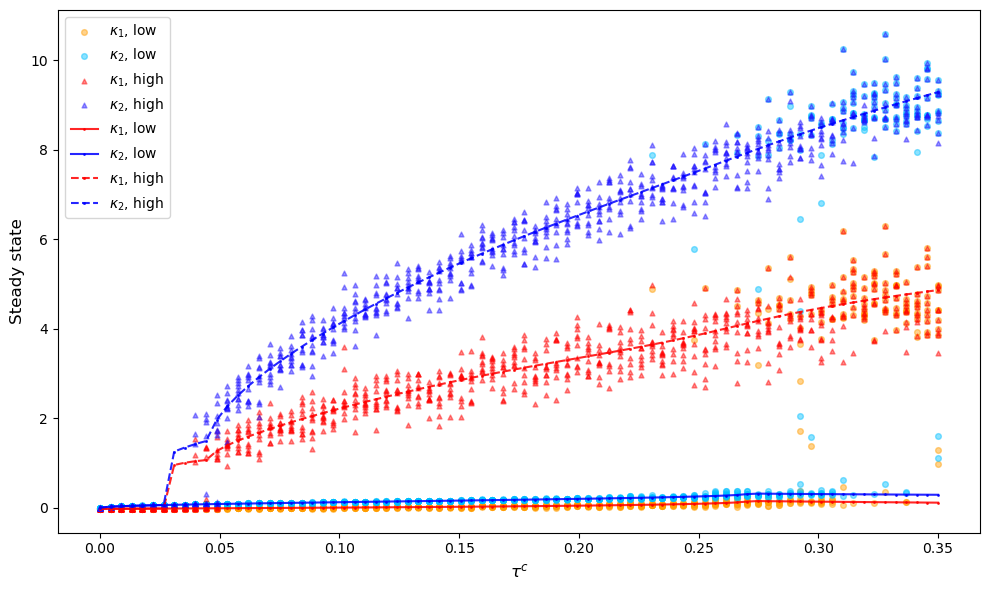

In [16]:
plt.figure(figsize=(10, 6))
alpha = 0.45  # 高透明度
s = 12       # 点大小
x = np.repeat(tau_c_values, N_trials)
plt.scatter(x, k1_simu_low.flatten(), 
            alpha=alpha, s=s+5, label='$\\kappa_1$, low', marker='o', color="#FF9D00FF")
plt.scatter(x, k2_simu_low.flatten(), 
            alpha=alpha, s=s+5, label='$\\kappa_2$, low', marker='o', color="#00BFFFFF")
plt.scatter(x, k1_simu_high.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_1$, high', marker='^', color="#FF0000FF")
plt.scatter(x, k2_simu_high.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_2$, high', marker='^', color="#2014FFFF")


plt.plot(tau_c_values, kappa1_near_zero, 'ro-', label='$\\kappa_1$, low', markersize=1.0, alpha=0.85)
plt.plot(tau_c_values, kappa2_near_zero, 'bo-', label='$\\kappa_2$, low', markersize=1.0, alpha=0.85)
plt.plot(tau_c_values, kappa1_large, 'rs--', label='$\\kappa_1$, high', markersize=1.0, alpha=0.85)
plt.plot(tau_c_values, kappa2_large, 'bs--', label='$\\kappa_2$, high', markersize=1.0, alpha=0.85)


# 添加标题和标签
plt.xlabel('$\\tau^c$', fontsize=12)
plt.ylabel('Steady state', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
        
     

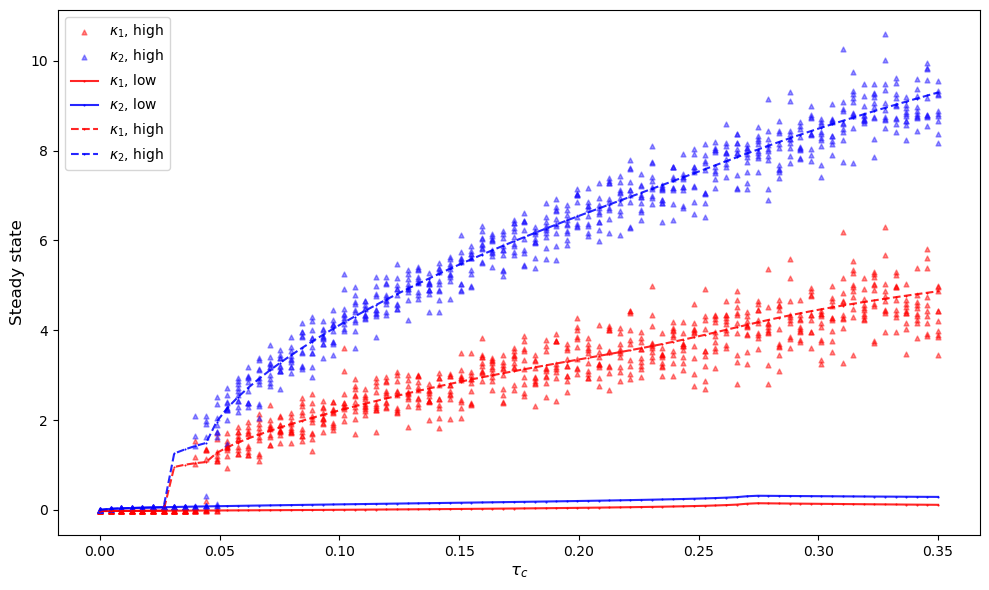

In [17]:
plt.figure(figsize=(10, 6))
alpha = 0.45  # 高透明度
s = 12       # 点大小
x = np.repeat(tau_c_values, N_trials)

plt.scatter(x, k1_simu_high.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_1$, high', marker='^', color="#FF0000FF")
plt.scatter(x, k2_simu_high.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_2$, high', marker='^', color="#2014FFFF")


plt.plot(tau_c_values, kappa1_near_zero, 'ro-', label='$\\kappa_1$, low', markersize=0.5, alpha=0.85)
plt.plot(tau_c_values, kappa2_near_zero, 'bo-', label='$\\kappa_2$, low', markersize=0.5, alpha=0.85)
plt.plot(tau_c_values, kappa1_large, 'rs--', label='$\\kappa_1$, high', markersize=0.5, alpha=0.85)
plt.plot(tau_c_values, kappa2_large, 'bs--', label='$\\kappa_2$, high', markersize=0.5, alpha=0.85)


# 添加标题和标签
plt.xlabel('$\\tau_c$', fontsize=12)
plt.ylabel('Steady state', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
        
     

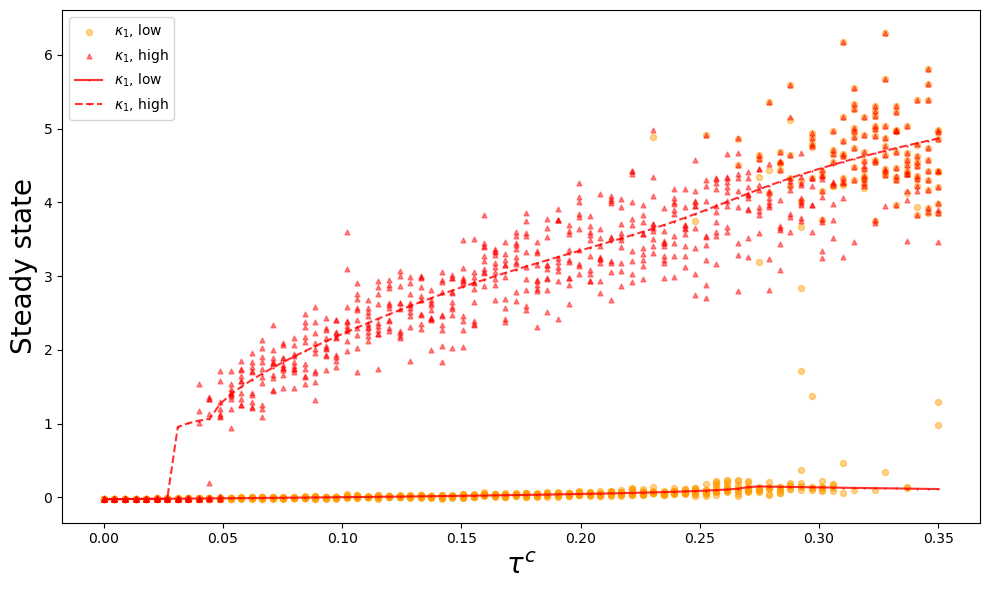

In [18]:
plt.figure(figsize=(10, 6))

# 定义透明度和点大小
alpha = 0.45  # 高透明度
s = 12       # 点大小
x = np.repeat(tau_c_values, N_trials)
plt.scatter(x, k1_simu_low.flatten(), 
            alpha=alpha, s=s+7, label='$\\kappa_1$, low', marker='o', color="#FF9D00FF")
plt.scatter(x, k1_simu_high.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_1$, high', marker='^', color="#FF0000FF")


plt.plot(tau_c_values, kappa1_near_zero, 'ro-', label='$\\kappa_1$, low', markersize=0.5, alpha=0.8)
plt.plot(tau_c_values, kappa1_large, 'rs--', label='$\\kappa_1$, high', markersize=0.5, alpha=0.8)


# 添加标题和标签
plt.xlabel('$\\tau^c$', fontsize=20)
plt.ylabel('Steady state', fontsize=20)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('./results/BISTEADY_g4.5_j0.003_kappa1.png')
plt.show()

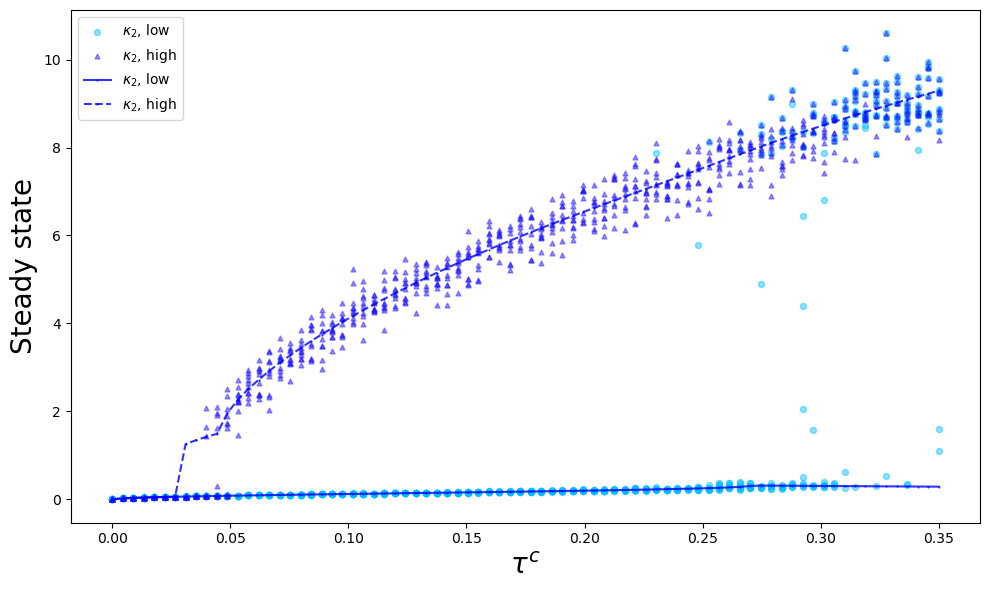

In [19]:
plt.figure(figsize=(10, 6))

alpha = 0.45  # 高透明度
s = 12       # 点大小

x = np.repeat(tau_c_values, N_trials)
plt.scatter(x, k2_simu_low.flatten(), 
            alpha=alpha, s=s+7, label='$\\kappa_2$, low', marker='o', color="#00BFFFFF")
plt.scatter(x, k2_simu_high.flatten(), 
            alpha=alpha, s=s, label='$\\kappa_2$, high', marker='^', color="#2014FFFF")


plt.plot(tau_c_values, kappa2_near_zero, 'bo-', label='$\\kappa_2$, low', markersize=0.5, alpha=0.8)
plt.plot(tau_c_values, kappa2_large, 'bs--', label='$\\kappa_2$, high', markersize=0.5, alpha=0.8)



# 添加标题和标签
plt.xlabel('$\\tau^c$', fontsize=20)
plt.ylabel('Steady state', fontsize=20)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('./results/BISTEADY_g4.5_j0.003_kappa2.png')
plt.show()
        
     